In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from scipy import stats
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from collections import Counter
import scanpy as sc
import anndata as an
import sys
sys.path.append('/mnt/c/MyPrograms/__github/scycle/')
import scycle as cc

import seaborn as sns

def smooth_adata_by_pooling(adata,X_embed,n_neighbours=10):
    adata_pooled = adata.copy()
    nbrs = NearestNeighbors(n_neighbors=n_neighbours).fit(X_embed)
    distances, indices = nbrs.kneighbors(X_embed)    
    adata_pooled.X = smooth_matrix_by_pooling(get_nd_array(adata.X),indices)
    if 'matrix' in adata.layers:
        adata_pooled.layers['matrix'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['matrix']),indices)
    if 'spliced' in adata.layers:
        adata_pooled.layers['spliced'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['spliced']),indices)
    if 'unspliced' in adata.layers:
        adata_pooled.layers['unspliced'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['unspliced']),indices)
    return adata_pooled

def smooth_matrix_by_pooling(matrix,indices):
    matrix_pooled = matrix.copy()
    for i in range(len(indices)):
        matrix_pooled[i,:] = np.mean(matrix[indices[i],:],axis=0)
    return matrix_pooled

def get_nd_array(arr):
    x = None
    if str(type(arr)):
        x = arr
    else:
        x = arr.toarray()
    return x

    
def preprocessing_without_pooling(adata):
    if Normalize_Totals:
        sc.pp.normalize_total(adata, target_sum=10000)
    if top_variable_genes>0:
        #sc.pp.highly_variable_genes(adata,n_top_genes=top_variable_genes,n_bins=20)
        #ind_genes = np.where(adata.var['highly_variable'])[0]
        vars = np.var(adata.X,axis=0)
        inds = np.flip(np.argsort(vars))
        ind_genes = inds[0:top_variable_genes]
        if 0 in vars[ind_genes]:
            ind_first_zero = np.argwhere(vars[ind_genes]==0)[0][0]
            ind_genes = ind_genes[0:ind_first_zero]
        #print(vars[ind_genes])
        adata = adata[:,ind_genes]
    if not Already_Log_Transformed:
        sc.pp.log1p(adata)
    sc.tl.pca(adata,n_comps=number_of_pcs)
    return adata

# pooling procedure
def pooling_procedure(adata):
    if n_neighbours_for_pooling>0:    
        adata_work = adata_orig.copy()
        preprocessing_without_pooling(adata)
        sc.tl.pca(adata,n_comps=number_of_pcs)
        X_pca = adata.obsm['X_pca']
        adata = smooth_adata_by_pooling(adata_work,X_pca,n_neighbours=n_neighbours_for_pooling)
    return adata

def preprocessing_dataset(adata):
    adata = preprocessing_without_pooling(adata)    
    sc.tl.pca(adata,n_comps=number_of_pcs)
    display(adata)
    return adata

def ismember(A, B):
    dct = {}
    for s,i in enumerate(B):
        dct[i] = s
    return [ dct[a] for a in A ]

def load_signature_file(file):
    sigs = {}
    with open(file,'r',encoding="utf8",errors='ignore') as fin:
        line = fin.readline().strip('\n').strip(' ')
        while line:
            parts = line.split('\t')
            lst = parts[2:]
            lst = [s.split('[')[0] for s in lst if not s=='']
            sigs[parts[0]] = lst
            line = fin.readline().strip('\n').strip(' ')
    return sigs

def load_weighted_signature_file(file):
    sigs = {}
    with open(file,'r',encoding="utf8",errors='ignore') as fin:
        line = fin.readline().strip('\n').strip(' ')
        while line:
            parts = line.split('\t')
            lst = parts[2:]
            lst1 = [s.split('[')[0] for s in lst if not s=='']
            weights = [float(s.split('[')[1].split(']')[0]) for s in lst if not s=='']
            #print(lst1,weights)
            sigs[parts[0]] = (lst1,weights)
            #sigs[parts[0]+'_W'] = weights
            line = fin.readline().strip('\n').strip(' ')
    return sigs

def calc_scores(anndata,signature_dict):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names = np.array(signature_dict[key])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        matrix_sel = matrix[:,inds]
        scores = np.mean(matrix_sel,axis=1)
        scores_dic[key] = scores
    return scores_dic

def calc_weighted_scores(anndata,signature_dict):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names_weights = signature_dict[key]
        names = names_weights[0]
        weights = np.array(names_weights[1])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        sel_names = anndata.var_names[inds]
        ind_in_names = ismember(sel_names,names)
        names1 = np.array(names)[ind_in_names]
        weights1 = np.array(weights)[ind_in_names]
        inds = ismember(names1,anndata.var_names)
        matrix_sel = matrix[:,inds]
        gene_means = np.mean(matrix_sel,axis=0)
        meanmat = np.outer(np.ones(matrix_sel.shape[0]),gene_means)
        matrix_sel = matrix_sel-meanmat
        scores = np.matmul(matrix_sel,weights1)
        scores_dic[key] = scores
    return scores_dic


def calc_histone_score(adata2k):
    histone_names1 = np.argwhere(adata2k.var_names.str.startswith('H1'))
    histone_names2 = np.argwhere(adata2k.var_names.str.startswith('H2'))
    histone_names3 = np.argwhere(adata2k.var_names.str.startswith('H3'))
    histone_names4 = np.argwhere(adata2k.var_names.str.startswith('H4'))
    histone_names5 = np.argwhere(adata2k.var_names.str.startswith('HIST'))
    histone_names = np.union1d(np.union1d(histone_names1,histone_names2),np.union1d(histone_names3,histone_names4))
    histone_names = np.union1d(histone_names,histone_names5)
    histone_names = adata2k.var_names[histone_names]
    print('Found histone genes:',*histone_names)
    inds_histones = np.where(np.isin(adata2k.var_names,histone_names))[0]
    matrix = adata2k.to_df().to_numpy()
    matrix_sel = matrix[:,inds_histones]
    scores = np.mean(matrix_sel,axis=1)
    return scores

def _compute_ica(adata,thr=2.0):
    adata.uns["scycle"] = {}
    cc.tl.dimensionality_reduction(adata,method='ica')

    idx_g1s = adata.uns['scycle']['find_cc_components']['indices']['G1-S']
    adata.uns['S-phase_genes'] = list(adata.var_names[adata.uns['dimRed'].S_[idx_g1s,:]>3])
    idx_g2m = adata.uns['scycle']['find_cc_components']['indices']['G2-M']
    adata.uns['G2-M_genes'] = list(adata.var_names[adata.uns['dimRed'].S_[idx_g2m,:]>3])
    #idx_g2m_inh = adata.uns['scycle']['find_cc_components']['indices']['G2-M-']
    #adata.uns['G2-M_INH_genes'] = list(adata.var_names[adata.uns['dimRed'].S_[idx_g2m_inh,:]>3])
    #idx_histone = adata.uns['scycle']['find_cc_components']['indices']['Histone']
    #adata.uns['Histone_IC_genes'] = list(adata.var_names[adata.uns['dimRed'].S_[idx_histone,:]>3])
    signature_dict = {'S-phase':adata.uns['S-phase_genes'],
                      'G2-M':adata.uns['G2-M_genes'],
                      #'G2-M-':adata.uns['G2-M_INH_genes'],
                      #'Histone_IC':adata.uns['Histone_IC_genes']
                      }  
    sc.pp.highly_variable_genes(adata,n_top_genes=2001,n_bins=20)
    ind_genes2k = np.where(adata.var['highly_variable'])[0]
    adata2k = adata[:,ind_genes2k]
    scores_dic = calc_scores(adata2k,signature_dict)
    for score in scores_dic:
        adata.obs[score] = scores_dic[score]
    adata.varm['P_dimRed'] = adata.uns['dimRed'].S_.T
    adata.uns['dimRed'] = None



/home/zinovyev/anaconda3/envs/singlecell/lib/python3.10/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
cell_line = 'CVCL_0069'
work_folder = 'tahoe-100/data/'
plate = 'plate7'
drug_name = 'Apalutamide'
#drug_name = 'Vemurafenib'

file = work_folder+plate+'_'+cell_line+'.h5ad'


In [2]:
!gsutil -m cp gs://tahoe100m_bycelllines/{plate}_{cell_line}.h5ad ./tahoe-100/data/

^C


In [24]:
adata = sc.read_h5ad(file)

In [ ]:
# Extract number of cells in each condition and the pseudobulk
import ast
drugs = list(set(adata.obs['drugname_drugconc']))
print(drugs)
number_of_drugs = len(drugs)
print(f'{number_of_drugs=}')
bulk_vals = {}
with open(file[:-5]+'_numberofcells.txt','w') as f:
    f.write('MEASUREMENT\tNUMBER_OF_CELLS\tNUMBER_OF_READS\n')
    for d in drugs:
        dt = ast.literal_eval(d)[0]
        drugname = str(dt[0])+'__'+str(dt[1])
        adf = adata[adata.obs['drugname_drugconc']==d,:]
        print(drugname,len(adf))
        f.write(drugname+'\t'+str(len(adf))+'\t'+str(int(adf.X.sum()))+'\n')
        bulk_vals[drugname] = adf.X.sum(axis=0)[0,:].A1
df = pd.DataFrame(data=bulk_vals)
df.index = adata.var_names
df.to_csv(file[:-5]+'_bulk.tsv',sep='\t')
display(df)

,Futibatinib__0.05,TAK-733__0.05,Anastrozole__0.05,TAK-901__0.05,Encorafenib__0.05,AZD-7648__0.05,Infigratinib__0.05,Erdafitinib __0.05,CP21R7__0.05,DMSO_TF__0.0,...,ULK-101__0.05,AZD2858__0.05,Gemcitabine__0.05,LJI308__0.05,c-Kit-IN-1__0.05,venetoclax__0.05,Paclitaxel__0.05,ETC-206__0.05,NG25__0.05,Dabrafenib__0.05
gene_name,,,,,,,,,,,,,,,,,,,,,
TSPAN6,32.0,52.0,89.0,63.0,56.0,85.0,60.0,53.0,35.0,104.0,...,17.0,43.0,125.0,42.0,0.0,60.0,53.0,49.0,32.0,42.0
TNMD,1.0,1.0,2.0,2.0,0.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
DPM1,201.0,414.0,547.0,277.0,392.0,425.0,333.0,321.0,270.0,764.0,...,227.0,405.0,1074.0,256.0,2.0,412.0,511.0,260.0,226.0,356.0
SCYL3,20.0,65.0,80.0,39.0,46.0,48.0,48.0,47.0,36.0,117.0,...,31.0,35.0,118.0,30.0,0.0,53.0,68.0,33.0,33.0,52.0
C1orf112,64.0,142.0,200.0,97.0,75.0,139.0,102.0,95.0,92.0,236.0,...,51.0,106.0,272.0,52.0,1.0,136.0,140.0,91.0,54.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000291313,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000291314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000291315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.


AnnData object with n_obs × n_vars = 93 × 2000
    uns: 'log1p'

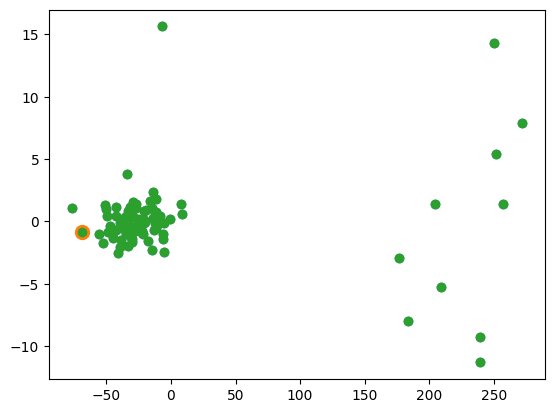

In [20]:
df = pd.read_csv(file[:-5]+'_bulk.tsv',sep='\t',index_col=0)
display(df)
adata_bulk = an.AnnData(X=df.T)
adata_bulk.var_names = df.index
adata_bulk.obs_names = df.columns
sc.pp.normalize_total(adata, target_sum=1000000)
top_variable_genes = 2000
vars = np.var(adata_bulk.X,axis=0)
inds = np.flip(np.argsort(vars))
ind_genes = inds[0:top_variable_genes]
if 0 in vars[ind_genes]:
    ind_first_zero = np.argwhere(vars[ind_genes]==0)[0][0]
    ind_genes = ind_genes[0:ind_first_zero]
adata_bulk = adata_bulk[:,ind_genes]
sc.pp.log1p(adata_bulk)
display(adata_bulk)
sc.tl.pca(adata_bulk)
xpca = adata_bulk.obsm['X_pca']
k = list(df.columns).index('DMSO_TF__0.0')
plt.scatter(xpca[:,0],xpca[:,1])
plt.scatter(xpca[k,0],xpca[k,1],s=100)
if False:
    for i in range(xpca.shape[0]):
        plt.text(xpca[i,0],xpca[i,1],df.columns[i])
plt.scatter(xpca[:,0],xpca[:,1])


In [7]:
drugs = list(set(adata.obs['drug']))
print(drugs)
number_of_drugs = len(drugs)
print(f'{number_of_drugs=}')

['Bentamapimod', 'vincristine', 'Gemcitabine', 'Belumosudil (mesylate)', 'PF-06260933', 'Methylprednisolone succinate', 'Celecoxib', 'Minodronic acid', 'Encorafenib', 'MK-3903', 'palbociclib', 'Ipatasertib', 'venetoclax', 'DTP3', 'NG25', 'AZD-7648', 'AT7519', 'AZD-8055', 'Brivudine', 'Pralsetinib', 'Capivasertib', 'BAY1125976', 'XRK3F2', 'Bimiralisib', 'AZD1390', 'Lapatinib ditosylate', 'Bortezomib', 'TAK-901', 'Infigratinib', 'c-Kit-IN-1', 'Hydroxyfasudil', 'Sapanisertib', 'GSK1059615', 'LB-100', 'BI-3406', 'Tucatinib', 'Tubulin inhibitor 6', 'DT-061', 'Adagrasib', 'HI-TOPK-032', 'DMSO_TF', '9-ING-41', 'Binimetinib', 'Dabrafenib', 'APTO-253', 'Volasertib', 'Capmatinib', 'MK-8353', 'CP21R7', 'SBI-0640756', 'Alpelisib', 'Tomivosertib', 'LY-2584702 (tosylate salt)', 'Oleic acid', 'ETC-206', 'PH-797804', 'Temuterkib', 'Erdafitinib ', 'IQ 1', 'BI-78D3', 'Paclitaxel', 'LY2090314', 'Everolimus', 'Pemigatinib', 'Belzutifan', 'Vemurafenib', 'EX229', 'ML264', 'Abemaciclib', 'Regorafenib', 'Lona

In [6]:
drug_name = 'Minodronic acid'
adatac = adata[adata.obs['drug']=='DMSO_TF',:]
adata_drug = adata[adata.obs['drug']==drug_name,:]
print(adatac)
print(adata_drug)
adatat = sc.concat([adatac,adata_drug])
print(adatat)
adatat.X = adatat.X.toarray()

View of AnnData object with n_obs × n_vars = 4763 × 62710
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate'
View of AnnData object with n_obs × n_vars = 1735 × 62710
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate'
<class 'anndata._core.views.SparseCSRView'>
AnnData object with n_obs × n_vars = 6498 × 62710
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate'


In [17]:
import ast
drugs = list(set(adata.obs['drug']))
adatac = adata[adata.obs['drug']=='DMSO_TF',:]
for drug_name in drugs:
    adata_drug = adata[adata.obs['drug']==drug_name,:]
    if len(adata_drug)>1000:
        adatat = sc.concat([adatac,adata_drug])
        adatat = adata_drug
        conc_vals = np.unique(list(adata_drug.obs['drugname_drugconc']))
        if len(conc_vals)==1:
            conc_vals = ast.literal_eval(conc_vals[0])[0]
            conc = str(conc_vals[1])
            print(drug_name,conc)
            adatat.write_h5ad(work_folder+plate+'_'+cell_line+'_'+drug_name+'_'+conc+'.h5ad',compression='gzip')
        else:
            print('ERROR: multiple values for the concentrations!!!',plate,cell_line,drug_name)
            break


ERROR: multiple values for the concentrations!!! plate13 CVCL_0023 Carbidopa (monohydrate)


In [27]:
minnumberofcellsfordrugresponse = 500
import ast
drugs = list(set(adata.obs['drug']))
cellnumbers = []
drugconclist = []
decomposed_filenames = []
k = 0
for drug_name in drugs:
    if '/' in drug_name:
        drug_name = drug_name.replace('/','-')
    adata_drug = adata[adata.obs['drug']==drug_name,:]
    conc_vals = np.unique(list(adata_drug.obs['drugname_drugconc']))
    for cv in conc_vals:
        cvt = ast.literal_eval(cv)
        adata_drug_conc =  adata_drug[adata_drug.obs['drugname_drugconc']==cv,:]
        if len(adata_drug_conc)>minnumberofcellsfordrugresponse:
            conc = str(cvt[0][1])
            print(k+1,drug_name,conc)
            dfn = plate+'_'+cell_line+'_'+drug_name+'_'+conc+'.h5ad'
            adata_drug_conc.write_h5ad(work_folder+dfn,compression='gzip')
            decomposed_filenames.append(dfn)
            cellnumbers.append(len(adata_drug_conc))
            if len(conc_vals)==1:
                drugconclist.append(drug_name)
            else:
                drugconclist.append(drug_name+'#'+conc)
            del adata_drug_conc
            k+=1


1 Topotecan (hydrochloride) 0.05
2 Phenytoin (sodium) 0.05
3 Thymopentin 0.05
4 Canagliflozin 0.05
5 Pitavastatin (Calcium) 0.05
6 Almonertinib (mesylate) 0.05
7 Benproperine (phosphate) 0.05
8 Tranilast 0.05
9 DMSO_TF 0.0
10 Pexidartinib (hydrochloride) 0.05
11 Erlotinib 0.05
12 Doxorubicin (hydrochloride) 0.05
13 Bisoprolol (hemifumarate) 0.05
14 Mozavaptan 0.05
15 Fenofibrate 0.05
16 Harringtonine 0.05
17 Orlistat 0.05
18 Silodosin 0.05
19 Trametinib (DMSO_TF solvate) 0.05
20 Bendamustine 0.05
21 Levobupivacaine (hydrochloride) 0.05
22 Entecavir (monohydrate) 0.05
23 Penfluridol 0.05
24 Menadione 0.05
25 Berbamine (dihydrochloride) 0.05
26 Simotinib 0.05
27 Monocrotaline 0.05
28 Apalutamide 0.05
29 Hesperidin 0.05
30 Rosiglitazone 0.05
31 Tolmetin 0.05
32 (S)-Crizotinib 0.05
33 Belumosudil 0.05
34 Peretinoin 0.05
35 Verteporfin 0.05
36 Imiquimod (maleate) 0.05
37 Tetracycline (hydrochloride) 0.05
38 Ligustrazine 0.05
39 Sivelestat (sodium tetrahydrate) 0.05
40 Verapamil 0.05
41 criz

In [22]:
print(drugconclist)

['Carbidopa (monohydrate)#0.05', 'Carbidopa (monohydrate)#0.5', 'Carbidopa (monohydrate)#5.0', 'Berbamine (dihydrochloride)#0.05', 'Berbamine (dihydrochloride)#0.5', 'Berbamine', 'Captopril', 'Topotecan (hydrochloride)#0.05', 'Topotecan (hydrochloride)#0.5', 'Topotecan (hydrochloride)#5.0', 'Ivabradine (hydrochloride)#0.05', 'Ivabradine (hydrochloride)#0.5', 'Ivabradine (hydrochloride)#5.0', 'Abemaciclib', 'Irinotecan (hydrochloride)#0.05', 'Irinotecan (hydrochloride)#0.5', 'Irinotecan (hydrochloride)#5.0', 'Flumatinib (mesylate)#0.05', 'Flumatinib (mesylate)#0.5', 'Flumatinib (mesylate)#5.0', 'Glasdegib#0.05', 'Glasdegib#0.5', 'Glasdegib#5.0', 'Malotilate', 'Pravastatin (sodium)#0.05', 'Pravastatin (sodium)#0.5', 'Pravastatin (sodium)#5.0', 'Naproxen#0.05', 'Naproxen#0.5', 'Naproxen#5.0', 'Nimesulide#0.05', 'Nimesulide#0.5', 'Nimesulide#5.0', 'Belumosudil#0.05', 'Belumosudil#0.5', 'Belumosudil#5.0', 'Almonertinib (mesylate)#0.05', 'Almonertinib (mesylate)#0.5', 'Chlorhexidine (diaceta

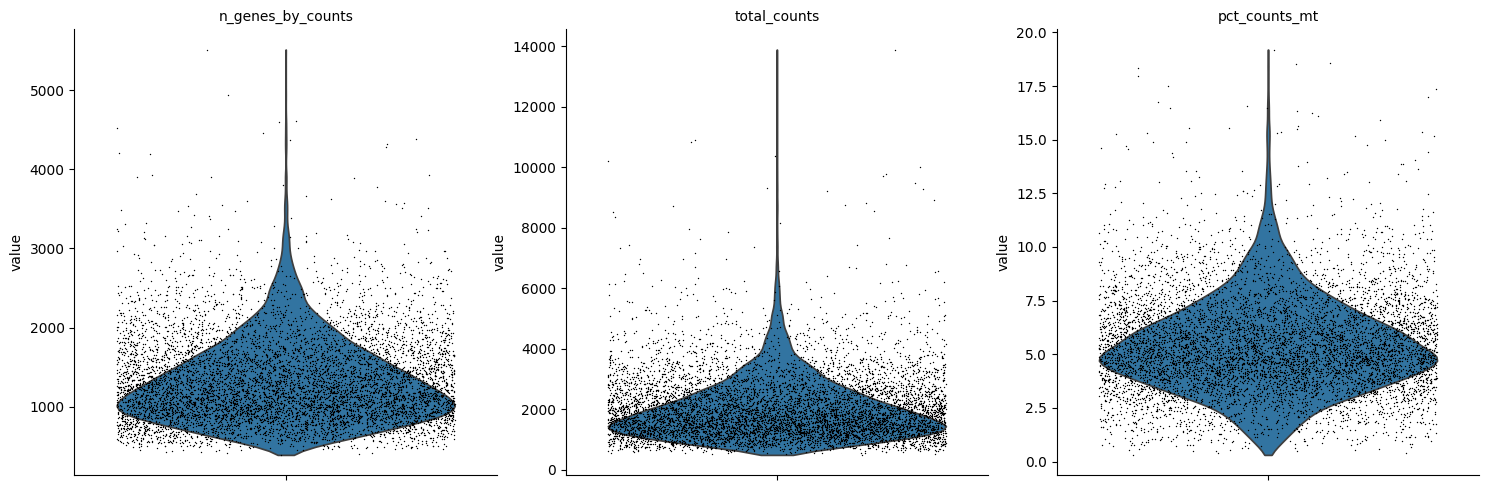

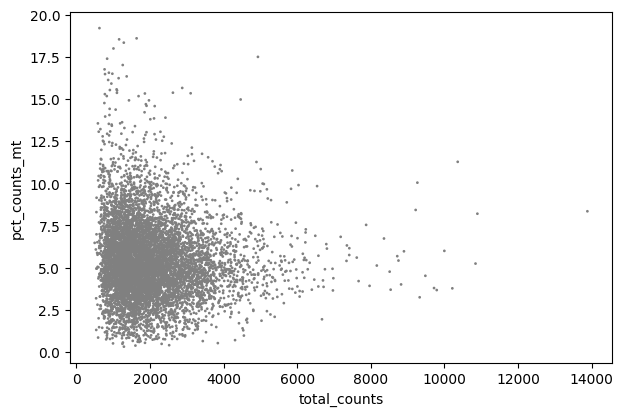

In [9]:
adata_orig = adatat
adata_orig.var['mt'] = adata_orig.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata_orig, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata_orig, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_orig, x='total_counts', y='pct_counts_mt')


In [10]:
top_variable_genes = 10000 # if negative then no selection of genes
Normalize_Totals = True
Already_Log_Transformed = False
n_neighbours_for_pooling = 10
number_of_pcs = 30

print('PREPROCESSING PARAMETERS:')
print('Already_Log_Transformed=',Already_Log_Transformed)
print('Normalize_Totals=',Normalize_Totals)
print('number_of_pcs=',number_of_pcs)
print('n_neighbours_for_pooling=',n_neighbours_for_pooling)
print('top_variable_genes=',top_variable_genes)

if n_neighbours_for_pooling>0:
    adatat1 = pooling_procedure(adatat)
adatat1 = preprocessing_dataset(adatat1)

adatat1.write(file[:-5]+'_processed.h5ad',compression='gzip')

PREPROCESSING PARAMETERS:
Already_Log_Transformed= False
Normalize_Totals= True
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.


AnnData object with n_obs × n_vars = 7755 × 10000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [7]:
adatat1 = sc.read_h5ad(file[:-5]+'_processed.h5ad')

In [12]:
sc.tl.pca(adatat1)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.10/site-packages/scanpy/plotting/_tools

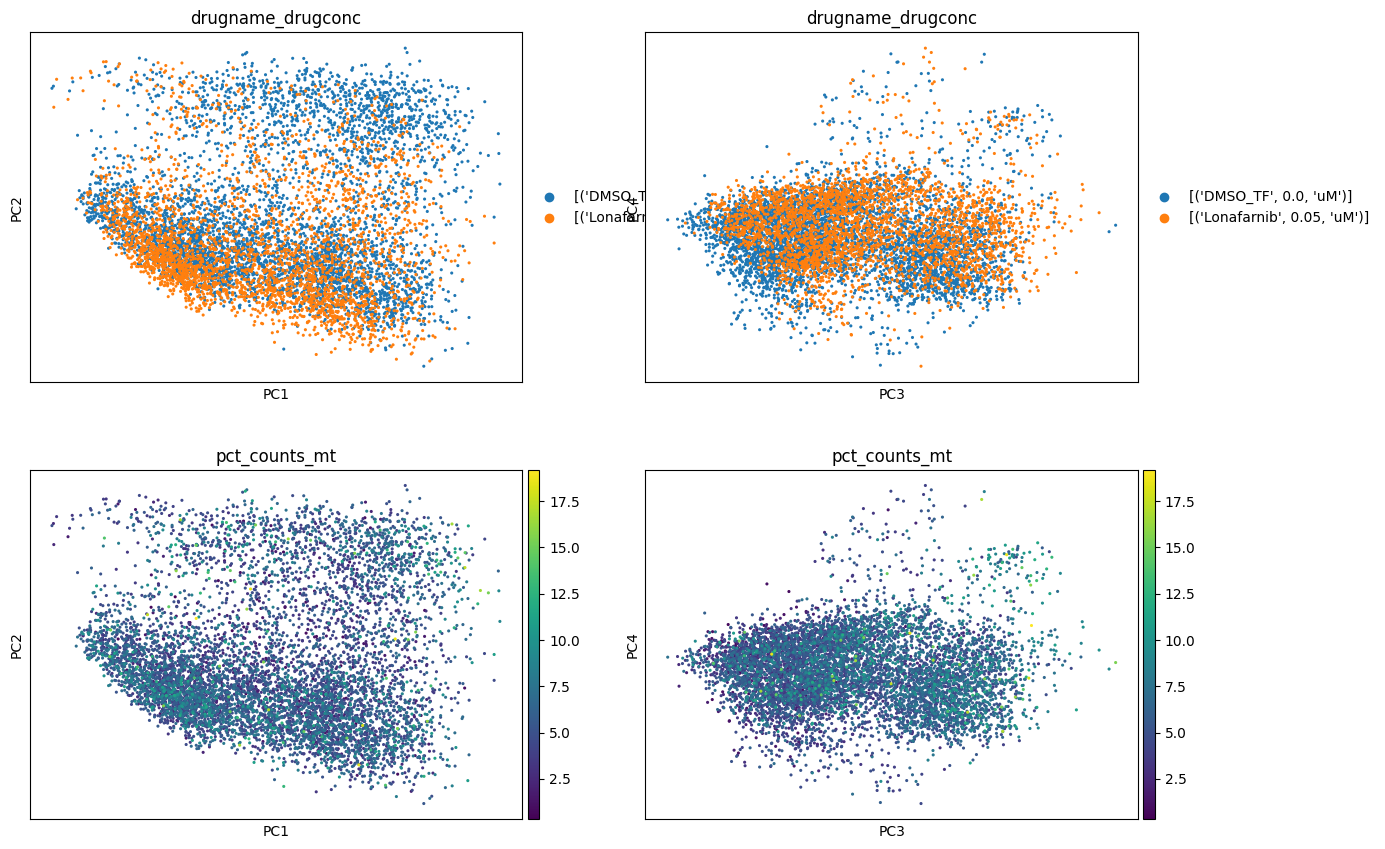

In [13]:
sc.pl.pca(
    adatat1,
    color=["drugname_drugconc", "drugname_drugconc", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=20,
)

/home/zinovyev/anaconda3/envs/singlecell/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


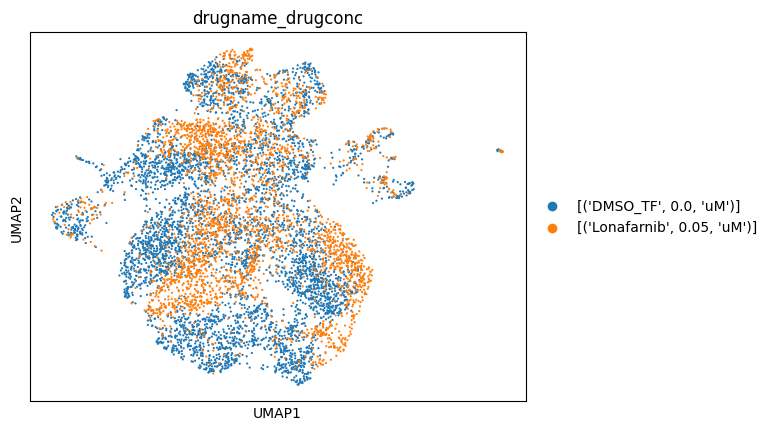

In [14]:
sc.pp.neighbors(adatat1)
sc.tl.umap(adatat1)
sc.pl.umap(
    adatat1,
    color="drugname_drugconc",
    size=10,
)

In [4]:
cc.tl.dimensionality_reduction(adatat1, method = 'ica', n_comps = 20, seed = 0)
cc.tl.enrich_components(adatat1)

/home/zinovyev/anaconda3/envs/singlecell/lib/python3.10/site-packages/scycle/tools/_dimensionality_reduction.py:75: UserWarning: Data has not been pre-processed using scycle (`pp.prep_pooling`or `pp.prep_simple`), before dimensionality reduction


-- Dimensionality reduction using ICA...
-- Done
--- Selected components:
G1-S: 1 (score=3.684027)
G2-M: 0 (score=6.111888)
--- Selected components:
G1-S: 1 (score=3.684027)
G2-M: 0 (score=6.111888)


In [10]:
_compute_ica(adatat1)

-- Dimensionality reduction using ICA...
-- Done
--- Selected components:
G1-S: 2 (score=3.879845)
G2-M: 0 (score=6.407407)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.10/site-packages/scanpy/preprocessing/_utils.py:11: RuntimeWarning: overflow encountered in multiply
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:247: RuntimeWarning: invalid value encountered in divide


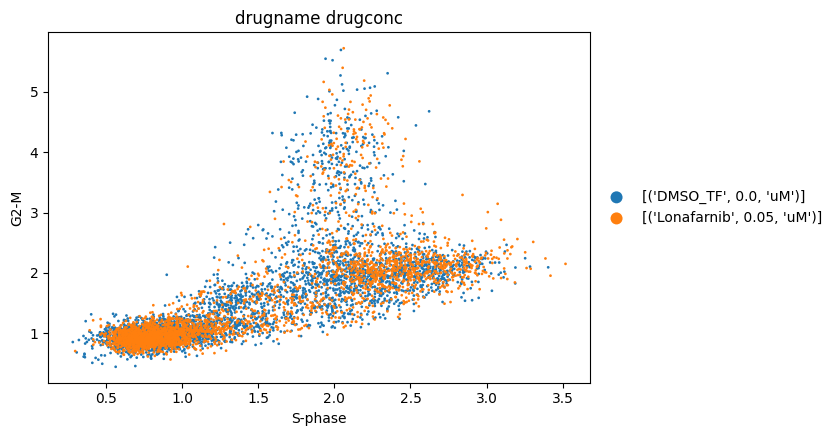

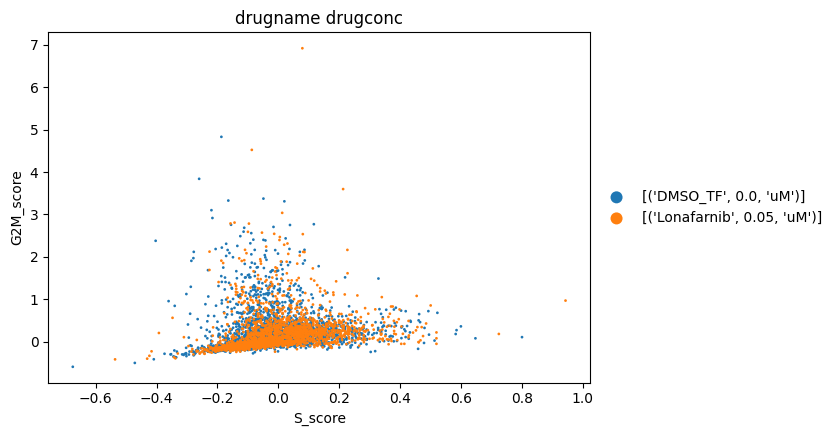

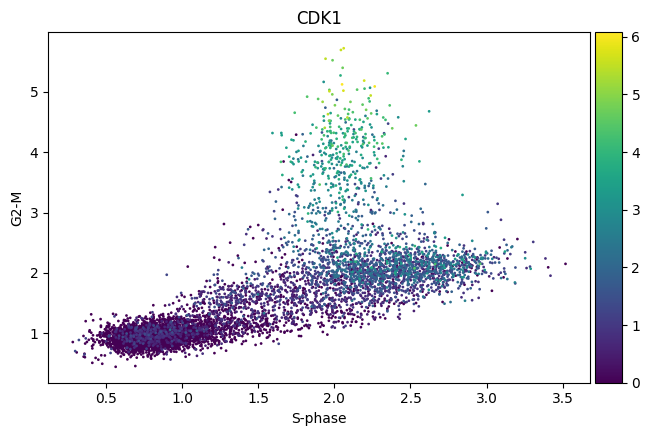

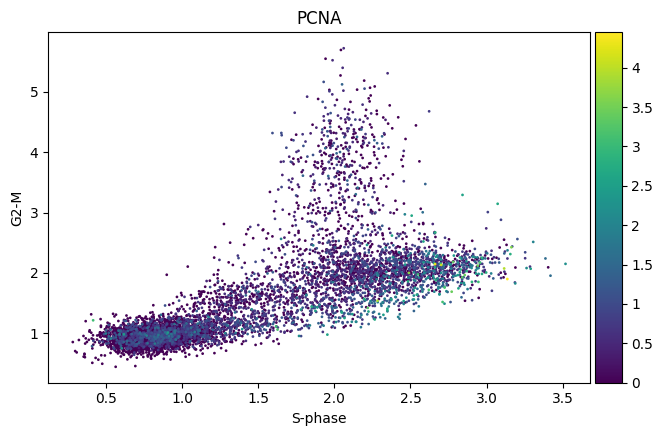

In [17]:
sc.pl.scatter(adatat1,x='S-phase',y='G2-M',color='drugname_drugconc')
sc.pl.scatter(adatat1,x='S_score',y='G2M_score',color='drugname_drugconc')
sc.pl.scatter(adatat1,x='S-phase',y='G2-M',color='CDK1')
sc.pl.scatter(adatat1,x='S-phase',y='G2-M',color='PCNA')

In [18]:
cc_genes = cc.data._cc_markers.cc_genes
print(len(cc_genes))
cc_genes = [g for g in cc_genes if g in adatat1.var_names]
print(len(cc_genes))
adata_cc = adatat1[:,cc_genes]


553
421


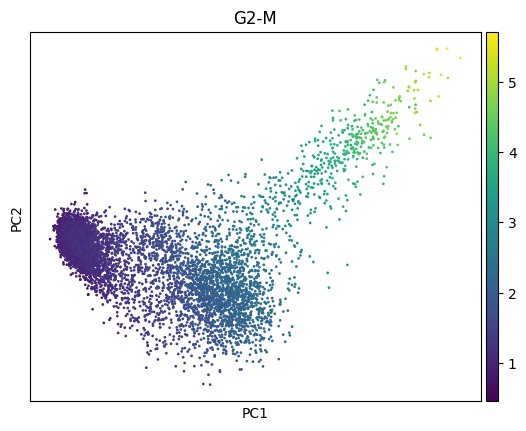

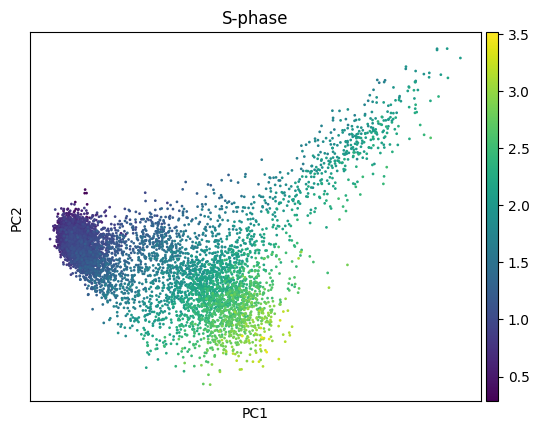

/home/zinovyev/anaconda3/envs/singlecell/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


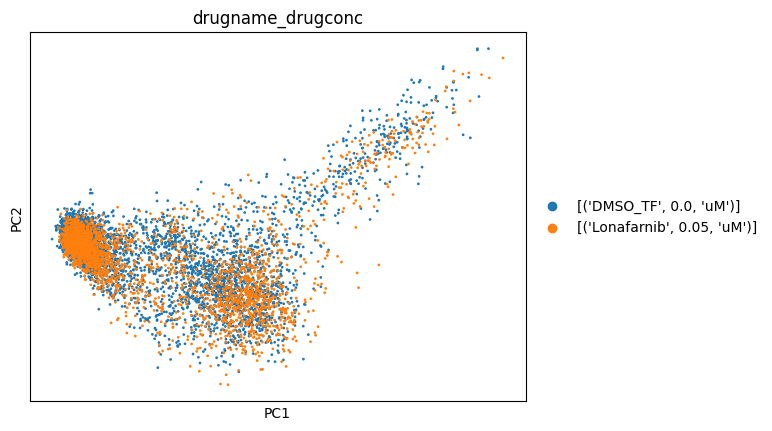

In [24]:
sc.tl.pca(adata_cc)
sc.pl.pca(adata_cc,color='G2-M')
sc.pl.pca(adata_cc,color='S-phase')
sc.pl.pca(adata_cc,color='drugname_drugconc')

In [58]:
filename = 'plate1_CVCL_1285.h5ad'
filename = 'plate11_CVCL_1125.h5ad'
infile = 'gs://tahoe100m_bycelllines/'+filename
# load the h5ad file
!gsutil -m cp {infile} ./tahoe-100/data/

^C


In [59]:

!rm ./tahoe-100/data/{filename} 

rm: cannot remove './tahoe-100/data/plate1_CVCL_1285.h5ad': No such file or directory


In [23]:
import subprocess
import os
filename = 'plate11_CVCL_1125.h5ad'
infile = 'gs://tahoe100m_bycelllines/'+filename
#subprocess.run(f'gsutil -m cp {infile} ./tahoe-100/data/')
os.system(f'gsutil -m cp {infile} ./tahoe-100/data/')

Copying gs://tahoe100m_bycelllines/plate11_CVCL_1125.h5ad...
\ [1/1 files][ 96.3 MiB/ 96.3 MiB] 100% Done   2.5 MiB/s ETA 00:00:00           
Operation completed over 1 objects/96.3 MiB.                                     


0

In [ ]:
import subprocess
result = subprocess.run(['gsutil','ls','gs://tahoe100m_bycelllines/'], capture_output=True, text=True)


In [10]:
s = 'gs://tahoe100m_analysis_pseudobulk/pseudobulk_files/plate10_CVCL_0023_bulk.tsv'
!gsutil ls {s}

CommandException: One or more URLs matched no objects.


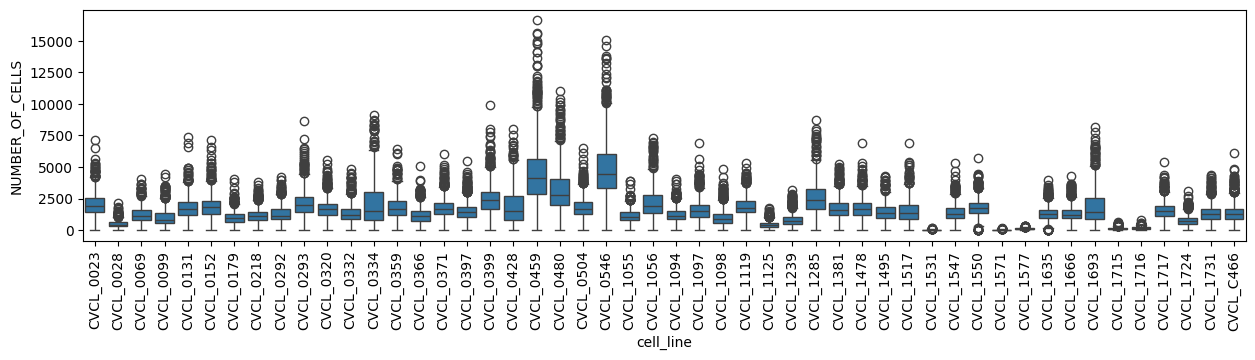

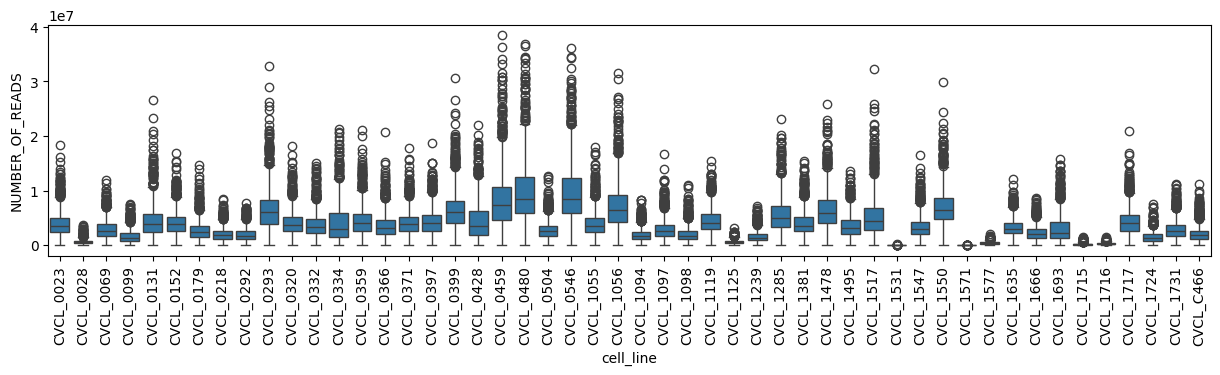

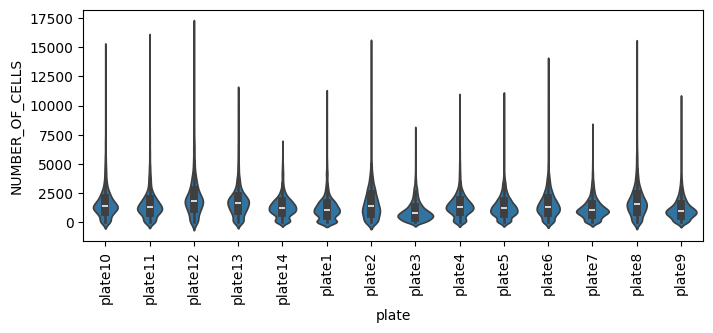

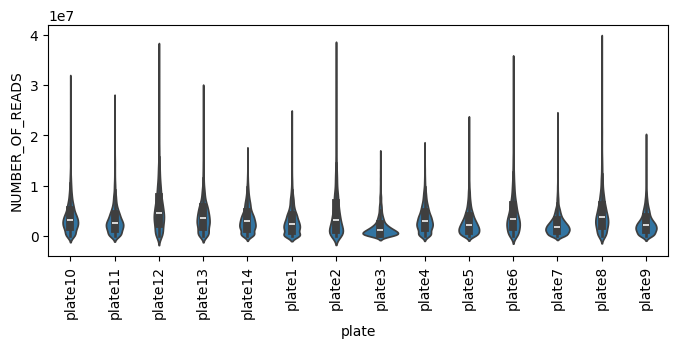

In [13]:
import pandas as pd
cellnumber_df = pd.read_csv('tahoe-100/data/cell_numbers/number_of_cells.tsv',sep='\t',index_col=0)
#display(cellnumber_df) 
fig = plt.figure(figsize=(15,3))
sns.boxplot(cellnumber_df,x='cell_line',y='NUMBER_OF_CELLS')
plt.xticks(rotation=90)
plt.show()
fig = plt.figure(figsize=(15,3))
sns.boxplot(cellnumber_df,x='cell_line',y='NUMBER_OF_READS')
plt.xticks(rotation=90)
plt.show()
fig = plt.figure(figsize=(8,3))
sns.violinplot(cellnumber_df,x='plate',y='NUMBER_OF_CELLS')
plt.xticks(rotation=90)
plt.show()
fig = plt.figure(figsize=(8,3))
sns.violinplot(cellnumber_df,x='plate',y='NUMBER_OF_READS')
plt.xticks(rotation=90)
plt.show()